<a href="https://colab.research.google.com/github/novtryrezki/Terbaru/blob/main/1FFNN_bs_64_ep_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import random
import shutil
import numpy as np
import tensorflow as tf
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split

In [2]:
# Melakukan mount pada Google Drive
drive.mount('/content/drive')

# Menentukan path file ZIP di Google Drive
zip_path = '/content/drive/MyDrive/images.zip'

# Membuat objek zip_ref
zip_ref = zipfile.ZipFile(zip_path, 'r')

# Mengekstrak file ZIP
extract_path ='/content/images'
zip_ref.extractall(extract_path)

# Tutup objek zip_ref setelah selesai
zip_ref.close()

Mounted at /content/drive


In [3]:
# Mendefinisikan path direktori dataset
dataset_dir = os.path.join(extract_path, 'images')
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
list_train = sorted(os.listdir(train_dir))
list_test = sorted(os.listdir(test_dir))

print("Daftar Angka pada Dataset Train yaitu : ", list_train)
print("Daftar Angka pada Dataset Test yaitu : ", list_test)

Daftar Angka pada Dataset Train yaitu :  ['angka 0', 'angka 1', 'angka 2', 'angka 3', 'angka 4', 'angka 5', 'angka 6', 'angka 7', 'angka 8', 'angka 9']
Daftar Angka pada Dataset Test yaitu :  ['angka 0', 'angka 1', 'angka 2', 'angka 3', 'angka 4', 'angka 5', 'angka 6', 'angka 7', 'angka 8', 'angka 9']


In [4]:
def count_images(directory):
    return sum(1 for file in os.listdir(directory) if file.endswith(('.jpg', '.jpeg', '.png', '.gif')))

# Menghitung jumlah gambar di data train
train_image_count = sum(count_images(os.path.join(train_dir, angka)) for angka in list_train)

# Menghitung jumlah gambar di data test
test_image_count = sum(count_images(os.path.join(test_dir, angka)) for angka in list_test)

print(f"Jumlah gambar di Dataset Train: {train_image_count}")
print(f"Jumlah gambar di Dataset Test: {test_image_count}")

Jumlah gambar di Dataset Train: 1763
Jumlah gambar di Dataset Test: 445


# Preprocessing

In [5]:
import cv2

def resize_images(directory, target_resolution):
    for angka in os.listdir(directory):
        angka_dir = os.path.join(directory, angka)
        for file_name in os.listdir(angka_dir):
            file_path = os.path.join(angka_dir, file_name)
            img = cv2.imread(file_path)
            resized_img = cv2.resize(img, (target_resolution[0], target_resolution[1]))
            cv2.imwrite(file_path, resized_img)

target_resolution = (52, 78)
resize_images(train_dir, target_resolution)
resize_images(test_dir, target_resolution)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Membuat generator data dengan augmentasi
image_size = (52, 78)
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 1763 images belonging to 10 classes.
Found 445 images belonging to 10 classes.


# Membuat Model FFNN

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
import math

img_size = 52*78*1

# Perhitungan jumlah neuron pada lapisan tersembunyi
hidden_neurons = 201

model1f = Sequential()
model1f.add(Flatten(input_shape=(52, 78, 1)))
model1f.add(Dense(hidden_neurons, activation='relu'))
model1f.add(Dense(10, activation='softmax'))

model1f.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Mendapatkan bobot dari model
weights = []
for layer in model1f.layers:
    weights.append(layer.get_weights())

print("Bobot dari model:")
for i, layer_weights in enumerate(weights):
    print("Layer", i+1)
    for j, w in enumerate(layer_weights):
        print("  Bobot {}: {}".format(j+1, w.shape))

Bobot dari model:
Layer 1
Layer 2
  Bobot 1: (4056, 201)
  Bobot 2: (201,)
Layer 3
  Bobot 1: (201, 10)
  Bobot 2: (10,)


In [9]:
# Menampilkan matriks bobot dan vektor bias dari setiap layer
for i, layer in enumerate(model1f.layers):
    weights = layer.get_weights()
    if weights:
        print("Layer", i+1)
        for j, w in enumerate(weights):
            if j == 0:
                print("  Bobot:")
            else:
                print("  Bias:")
            print("    Ukuran:", w.shape)
            print("    Nilai:")
            print(w)

Layer 2
  Bobot:
    Ukuran: (4056, 201)
    Nilai:
[[ 0.02646162  0.03748464 -0.02548001 ... -0.02029525 -0.00113392
  -0.0211352 ]
 [-0.01737732  0.03496422  0.01976135 ... -0.00950383 -0.00655026
  -0.00295303]
 [-0.03520881 -0.02501854  0.01836045 ... -0.01545093  0.0179998
  -0.0292426 ]
 ...
 [-0.01645296 -0.03445268 -0.02175238 ... -0.00235507  0.01963042
   0.01558074]
 [-0.0346676  -0.01581688  0.03282856 ...  0.02633043 -0.00271088
  -0.01089671]
 [ 0.00763262  0.00326994  0.02549425 ...  0.01293104  0.02331089
  -0.0370093 ]]
  Bias:
    Ukuran: (201,)
    Nilai:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [10]:
model1f.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4056)              0         
                                                                 
 dense (Dense)               (None, 201)               815457    
                                                                 
 dense_1 (Dense)             (None, 10)                2020      
                                                                 
Total params: 817477 (3.12 MB)
Trainable params: 817477 (3.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
history = model1f.fit(train_generator, epochs=20, verbose = 1)

Epoch 1/20
28/28 [==============================] - 3s 69ms/step - loss: 2.0870 - accuracy: 0.2751
Epoch 2/20
28/28 [==============================] - 2s 69ms/step - loss: 1.9624 - accuracy: 0.3392
Epoch 3/20
28/28 [==============================] - 2s 67ms/step - loss: 1.8960 - accuracy: 0.3857
Epoch 4/20
28/28 [==============================] - 3s 94ms/step - loss: 1.9335 - accuracy: 0.3381
Epoch 5/20
28/28 [==============================] - 3s 103ms/step - loss: 1.8557 - accuracy: 0.3823
Epoch 6/20
28/28 [==============================] - 2s 73ms/step - loss: 1.8231 - accuracy: 0.3942
Epoch 7/20
28/28 [==============================] - 2s 69ms/step - loss: 1.8040 - accuracy: 0.3976
Epoch 8/20
28/28 [==============================] - 2s 66ms/step - loss: 1.7788 - accuracy: 0.4022
Epoch 9/20
28/28 [==============================] - 2s 66ms/step - loss: 1.8184 - accuracy: 0.3902
Epoch 10/20
28/28 [==============================] - 3s 105ms/step - loss: 1.7927 - accuracy: 0.3988
Epoch 1

#Matriks Konfusi

7/7 [==============================] - 0s 29ms/step


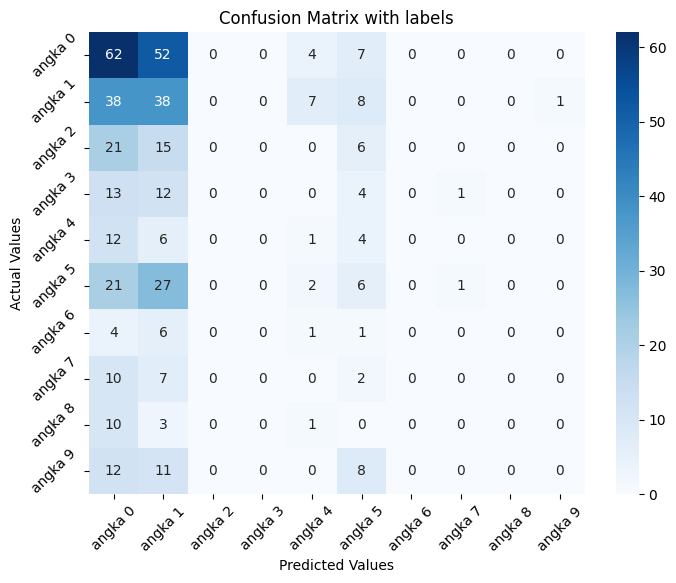

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Fungsi untuk mendapatkan prediksi model dan label sebenarnya
def get_predictions_and_labels(model, data_generator):
    predictions = model.predict(data_generator)
    true_classes = data_generator.classes
    return predictions, true_classes

# Mendapatkan prediksi dan label sebenarnya untuk data uji
y_pred_prob, y_true = get_predictions_and_labels(model1f, test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Membuat matriks konfusi
cf_matrix = confusion_matrix(y_true, y_pred)

# Membuat visualisasi matriks konfusi
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', ax=ax)

# Menetapkan label dan judul
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

class_labels = list(test_generator.class_indices.keys())

# Menetapkan label pada sumbu x dan y sesuai dengan jenis kelas
ax.xaxis.set_ticklabels(class_labels, rotation=45)
ax.yaxis.set_ticklabels(class_labels, rotation=45)

# Menampilkan visualisasi Matriks Konfusi
plt.show()

In [15]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.24044943820224718
